## 0. Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

pt.update_plot_defaults()


# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10000], shuffle=True, generator=data_generator)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10000:], batch_size=10000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)
debug_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10])

epochs = 1
data_seed = 0
network_seed = 42

In [6]:
def diagnose_mnist_network(network, test_dataloader, train_sub_dataloader, supervised=True):
    
    title = 'Initial'
    pt.plot_batch_accuracy(network, test_dataloader, title=title)
    
    plt.figure()
    plt.imshow(network.H1.E.Input.E.weight.data, aspect='auto', interpolation='none')
    plt.suptitle('%s Weights: H1.E.Input.E' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.H1.E.H1.FBI.weight.data, aspect='auto', interpolation='none')
    plt.suptitle('%s Weights: H1.E.H1.FBI' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.H1.FBI.H1.E.weight.data, aspect='auto', interpolation='none')
    plt.suptitle('%s Weights: H1.FBI.H1.E' % title)
    plt.colorbar()
    
    try:
        plt.figure()
        plt.imshow(network.H1.FBI.H1.FBI.weight.data, aspect='auto', interpolation='none')
        plt.suptitle('%s Weights: H1.FBI.H1.FBI' % title)
        plt.colorbar()
    except:
        pass

    plt.figure()
    plt.imshow(network.Output.E.H1.E.weight.data, aspect='auto', interpolation='none')
    plt.suptitle('%s Weights: Output.E.H1.E' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.Output.E.Output.FBI.weight.data, aspect='auto', interpolation='none')
    plt.suptitle('%s Weights: Output.E.Output.FBI' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.Output.FBI.Output.E.weight.data, aspect='auto', interpolation='none')
    plt.suptitle('%s Weights: Output.FBI.Output.E' % title)
    plt.colorbar()
    
    try:
        plt.figure()
        plt.imshow(network.Output.FBI.Output.FBI.weight.data, aspect='auto', interpolation='none')
        plt.suptitle('%s Weights: Output.FBI.Output.FBI' % title)
        plt.colorbar()
    except:
        pass
    
    plt.figure()
    plt.imshow(network.Input.E.activity.detach().T, aspect='auto', interpolation='none')
    plt.suptitle('%s Activity: Input.E' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.H1.E.activity.detach().T, aspect='auto', interpolation='none')
    plt.suptitle('%s Activity: H1.E' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.H1.FBI.activity.detach().T, aspect='auto', interpolation='none')
    plt.suptitle('%s Activity: H1.FBI' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.Output.E.activity.detach().T, aspect='auto', interpolation='none')
    plt.suptitle('%s Activity: Output.E' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.Output.FBI.activity.detach().T, aspect='auto', interpolation='none')
    plt.suptitle('%s Activity: Output.FBI' % title)
    plt.colorbar()
    
    network.train_and_validate(train_sub_dataloader, 
                                  val_dataloader, 
                                  epochs=epochs,
                                  val_interval=(-2, -1, 1),
                                  store_history=False, 
                                  store_weights=True,
                                  store_weights_interval=(0, -1, 100),
                                  status_bar=True)
    
    if not supervised:
        _, sorted_output_idx = ut.sort_by_val_history(network)
    else:
        sorted_output_idx = torch.arange(0, network.val_output_history.shape[-1])
    pt.plot_batch_accuracy(network, test_dataloader, sorted_output_idx=sorted_output_idx, title='Final')
    pt.plot_train_loss_history(network)
    pt.evaluate_test_loss_history(network, test_dataloader, sorted_output_idx=sorted_output_idx, store_history=True, plot=True)
        
    title = 'Final'
    
    plt.figure()
    plt.imshow(network.H1.E.Input.E.weight.data, aspect='auto', interpolation='none')
    plt.suptitle('%s Weights: H1.E.Input.E' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.H1.E.H1.FBI.weight.data, aspect='auto', interpolation='none')
    plt.suptitle('%s Weights: H1.E.H1.FBI' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.H1.FBI.H1.E.weight.data, aspect='auto', interpolation='none')
    plt.suptitle('%s Weights: H1.FBI.H1.E' % title)
    plt.colorbar()
    
    try:
        plt.figure()
        plt.imshow(network.H1.FBI.H1.FBI.weight.data, aspect='auto', interpolation='none')
        plt.suptitle('%s Weights: H1.FBI.H1.FBI' % title)
        plt.colorbar()
    except:
        pass

    plt.figure()
    plt.imshow(network.Output.E.H1.E.weight.data, aspect='auto', interpolation='none')
    plt.suptitle('%s Weights: Output.E.H1.E' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.Output.E.Output.FBI.weight.data, aspect='auto', interpolation='none')
    plt.suptitle('%s Weights: Output.E.Output.FBI' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.Output.FBI.Output.E.weight.data, aspect='auto', interpolation='none')
    plt.suptitle('%s Weights: Output.FBI.Output.E' % title)
    plt.colorbar()
    
    try:
        plt.figure()
        plt.imshow(network.Output.FBI.Output.FBI.weight.data, aspect='auto', interpolation='none')
        plt.suptitle('%s Weights: Output.FBI.Output.FBI' % title)
        plt.colorbar()
    except:
        pass
    
    plt.figure()
    plt.imshow(network.Input.E.activity.detach().T, aspect='auto', interpolation='none')
    plt.suptitle('%s Activity: Input.E' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.H1.E.activity.detach().T, aspect='auto', interpolation='none')
    plt.suptitle('%s Activity: H1.E' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.H1.FBI.activity.detach().T, aspect='auto', interpolation='none')
    plt.suptitle('%s Activity: H1.FBI' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.Output.E.activity.detach().T, aspect='auto', interpolation='none')
    plt.suptitle('%s Activity: Output.E' % title)
    plt.colorbar()

    plt.figure()
    plt.imshow(network.Output.FBI.activity.detach().T, aspect='auto', interpolation='none')
    plt.suptitle('%s Activity: Output.FBI' % title)
    plt.colorbar()
    
    plt.show()

### Backprop (no weight contraints)

In [ ]:
# Create network
network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_relu_SGD_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

# Train network
data_generator.manual_seed(data_seed)

bp_network.train_and_validate(train_sub_dataloader, 
                              val_dataloader, 
                              epochs=epochs,
                              val_interval=(-2, -1, 1),
                              store_history=False, 
                              store_weights=True,
                              store_weights_interval=(0, -1, 100),
                              status_bar=True)

In [ ]:
pt.plot_batch_accuracy(bp_network, test_dataloader, title='Final')
pt.plot_train_loss_history(bp_network)
pt.plot_validate_loss_history(bp_network)
pt.evaluate_test_loss_history(bp_network, test_dataloader, store_history=True, plot=True)

# pt.plot_MNIST_examples(bp_network, test_dataloader)
plt.show()

### Backprop (Dale's Law)

In [3]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/20221219_EIANN_1_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bpDale_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

Batch accuracy = 10.210000038146973%


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Batch accuracy = 83.94000244140625%


/Users/aaronmil/src/EIANN/EIANN/plot.py:201: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/aaronmil/src/EIANN/EIANN/plot.py:255: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/1v/63_09y215ml8k3bkh1my_dfw0000gn/T/ipykernel_32636/355546063.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


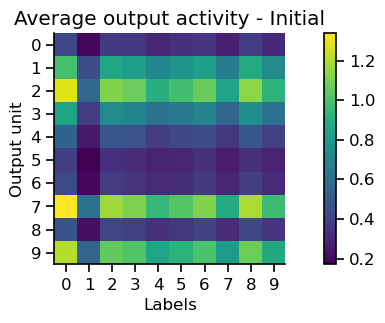

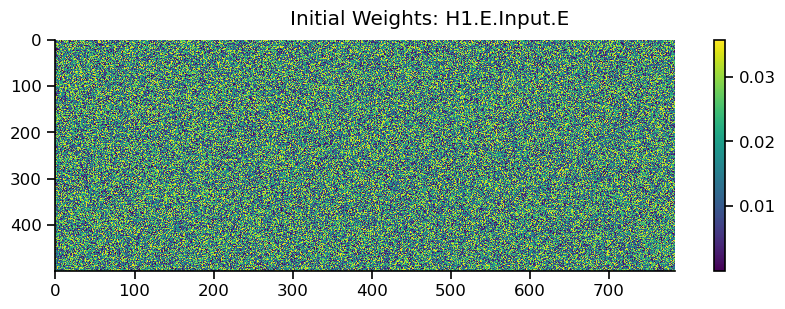

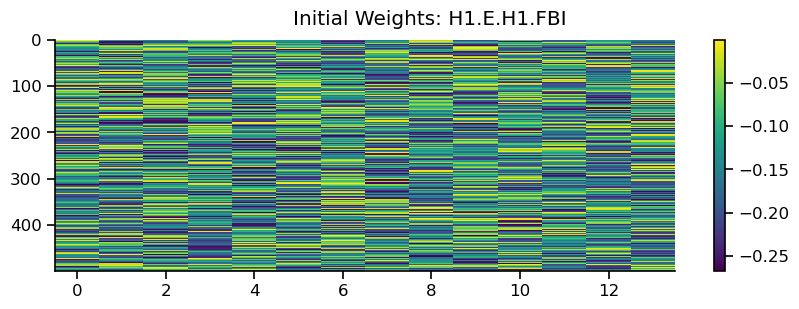

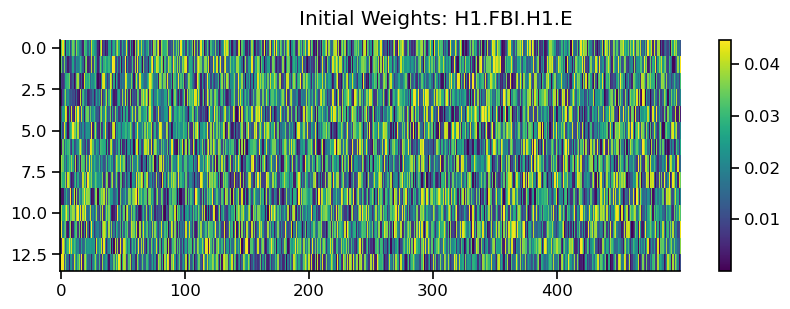

<Figure size 1000x300 with 0 Axes>

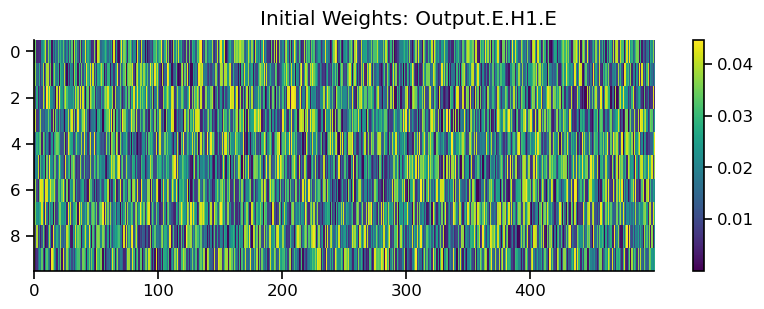

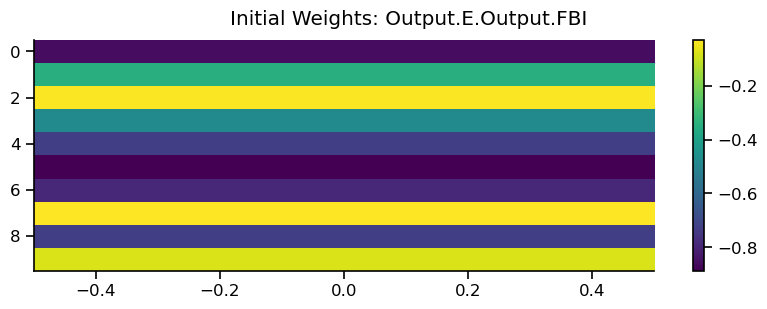

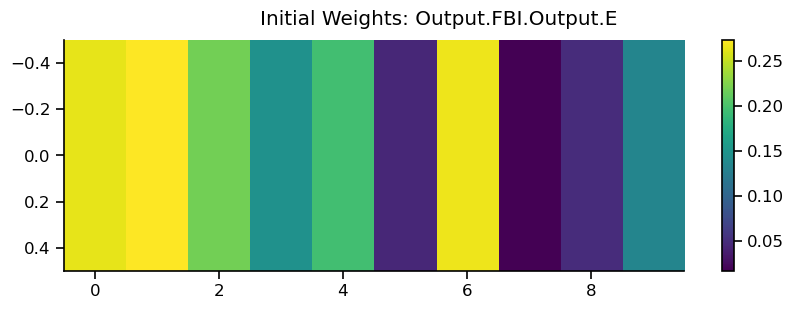

<Figure size 1000x300 with 0 Axes>

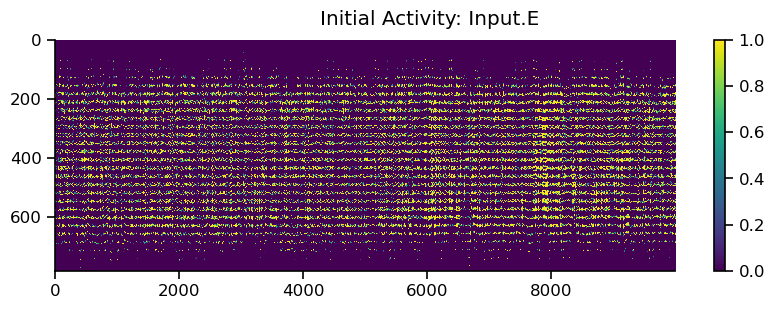

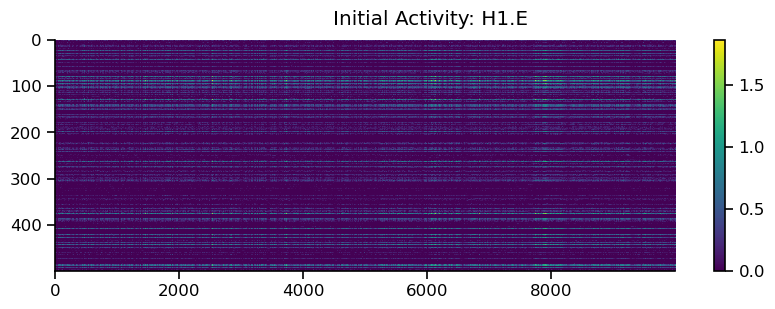

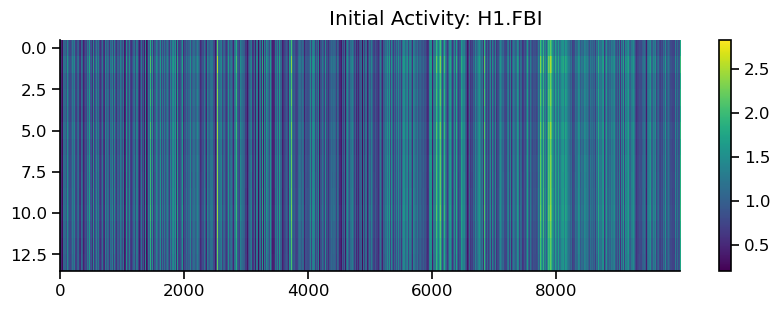

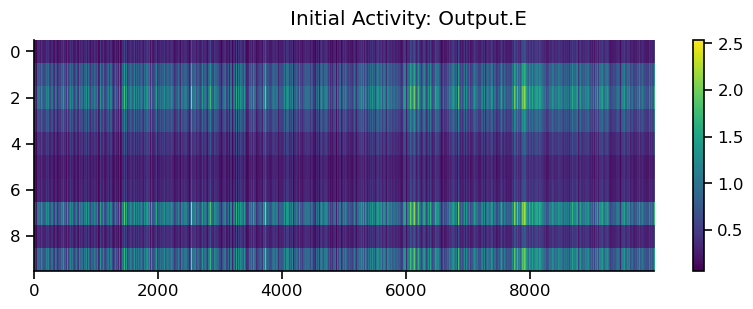

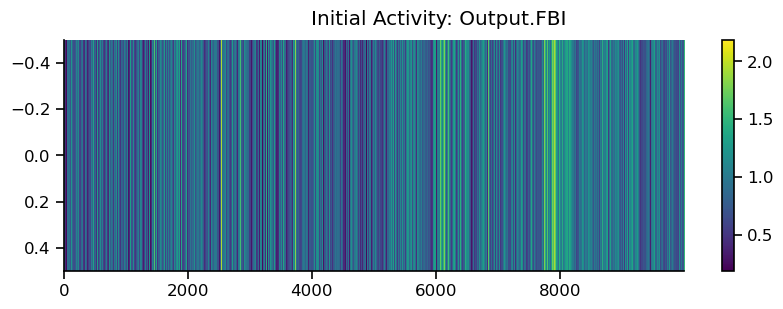

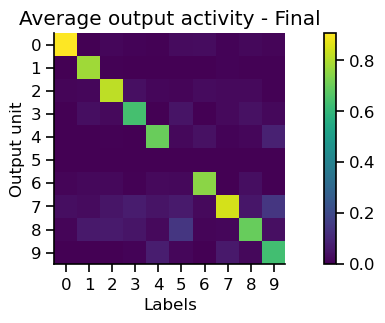

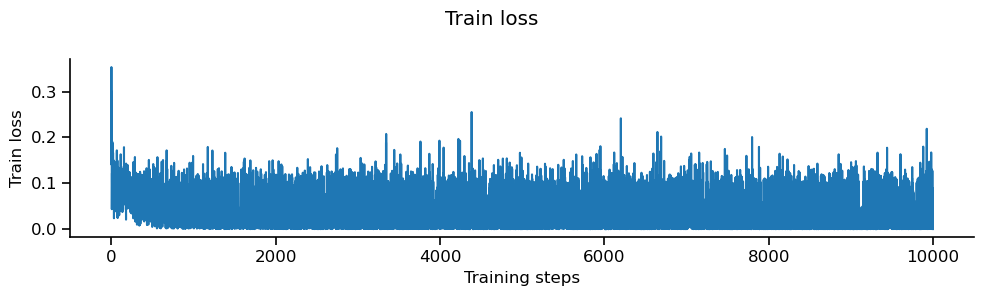

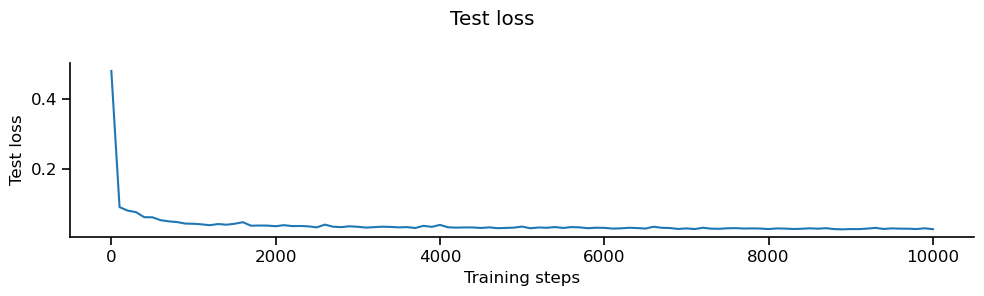

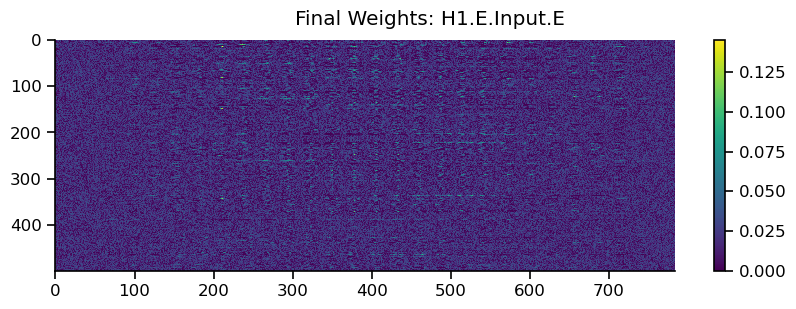

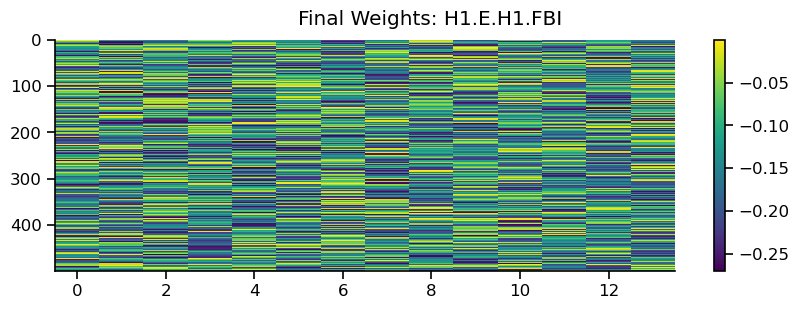

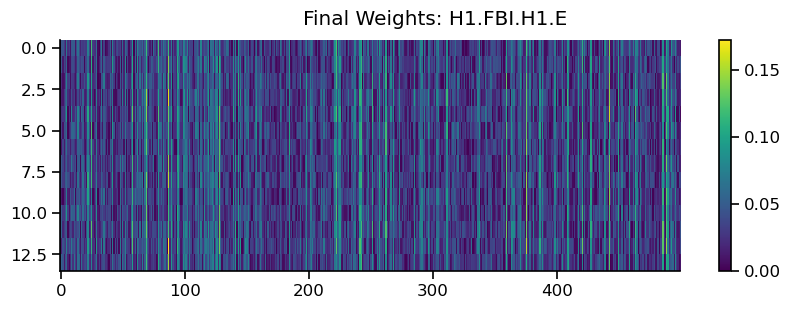

<Figure size 1000x300 with 0 Axes>

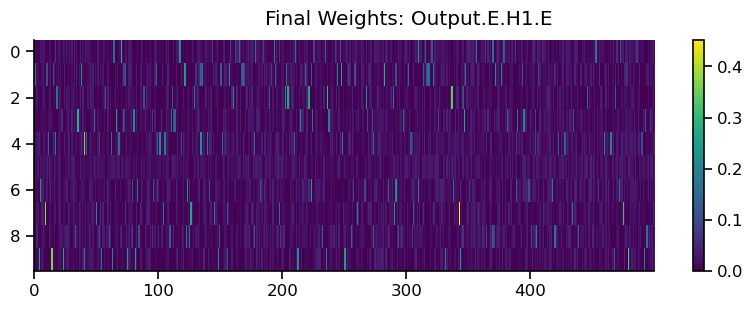

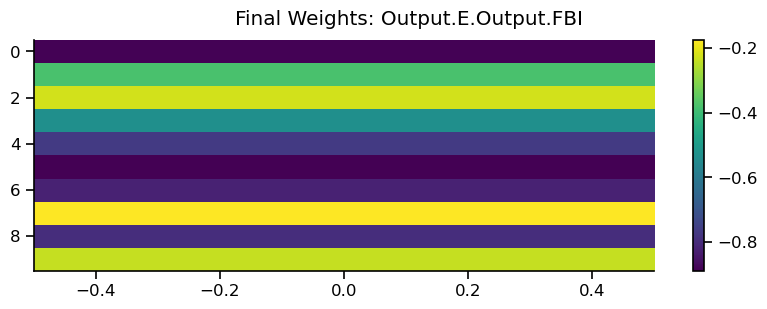

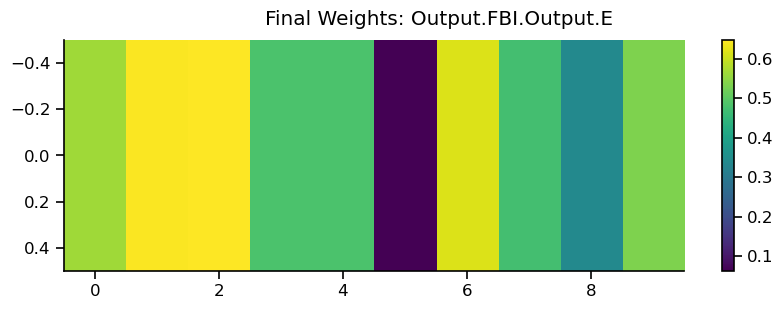

<Figure size 1000x300 with 0 Axes>

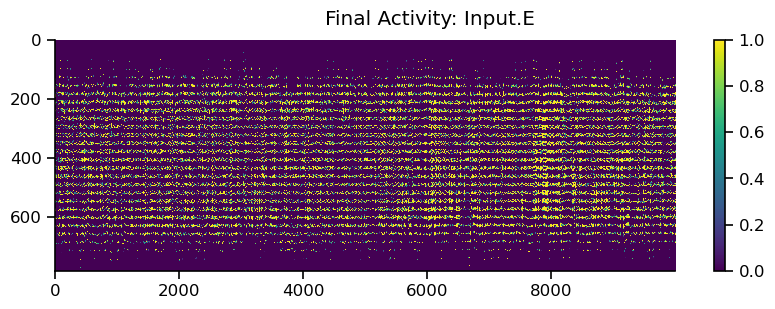

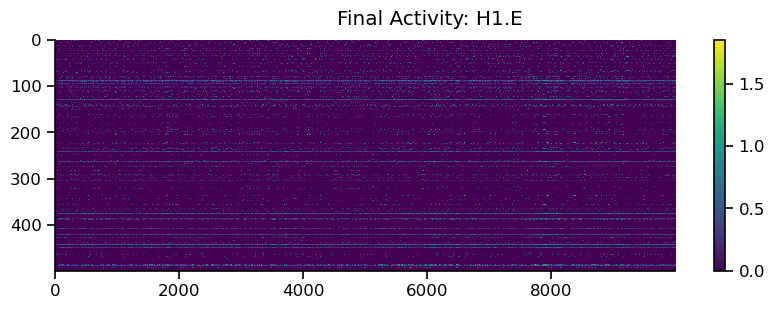

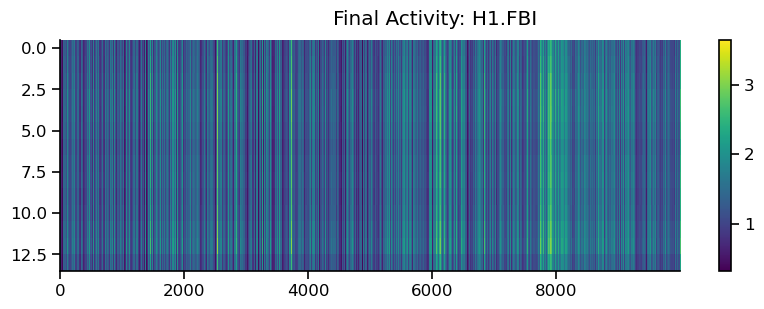

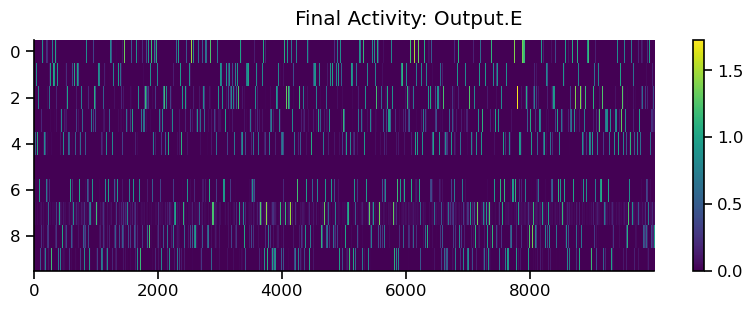

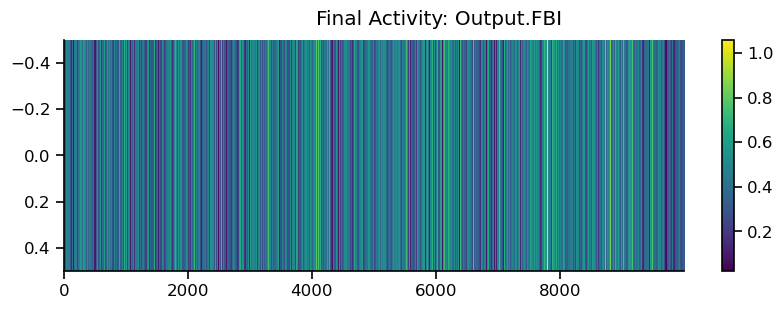

In [7]:
data_generator.manual_seed(data_seed)
diagnose_mnist_network(bpDale_network, test_dataloader, train_sub_dataloader, supervised=True)

In [ ]:
# Train network
data_generator.manual_seed(data_seed)
bpDale_network.train_and_validate(train_sub_dataloader, 
                              val_dataloader, 
                              epochs=epochs,
                              val_interval=(-2, -1, 1),
                              store_history=False, 
                              store_weights=True,
                              store_weights_interval=(0, -1, 100),
                              status_bar=True)

pt.plot_batch_accuracy(bpDale_network, test_dataloader, title='Final')
pt.plot_train_loss_history(bpDale_network)
pt.plot_validate_loss_history(bpDale_network)
pt.evaluate_test_loss_history(bpDale_network, test_dataloader, store_history=True, plot=True)

# pt.plot_MNIST_examples(bpDale_network, test_dataloader)
plt.show()

In [ ]:
i = 0
j = -1

print(torch.min(bpDale_network.Input.E.activity_history[i,-1,j]), torch.max(bpDale_network.Input.E.activity_history[i,-1,j]))
plt.figure()
plt.hist(bpDale_network.Input.E.activity_history[i,-1,j], bins=10)

print(torch.min(bpDale_network.H1.E.activity_history[i,-1,j]), torch.max(bpDale_network.H1.E.activity_history[i,-1,j]))
plt.figure()
plt.hist(bpDale_network.H1.E.activity_history[i,-1,j], bins=10)

print(torch.min(bpDale_network.H1.FBI.activity_history[i,-1,j]), torch.max(bpDale_network.H1.FBI.activity_history[i,-1,j]))
plt.figure()
plt.hist(bpDale_network.H1.FBI.activity_history[i,-1,j], bins=10)

print(torch.min(bpDale_network.Output.E.activity_history[i,-1,j]), torch.max(bpDale_network.Output.E.activity_history[i,-1,j]))
plt.figure()
plt.hist(bpDale_network.Output.E.activity_history[i,-1,j], bins=10)

In [ ]:
i = 0
plt.figure()
plt.imshow(bpDale_network.Input.E.activity_history[i,-1].T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(bpDale_network.H1.E.activity_history[i,-1].T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(bpDale_network.H1.FBI.activity_history[i,-1].T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(bpDale_network.Output.E.activity_history[i,-1].T, aspect='auto', interpolation='none')
plt.colorbar()

In [ ]:
plt.figure()
plt.imshow(bpDale_network.H1.E.Input.E.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(bpDale_network.H1.E.H1.FBI.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(bpDale_network.H1.FBI.H1.E.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(bpDale_network.Output.E.H1.E.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(bpDale_network.Output.E.Output.FBI.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(bpDale_network.Output.FBI.Output.E.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

In [ ]:
# Train network
bpDale_network.reset_history()

data_generator.manual_seed(data_seed)
bpDale_network.train(train_sub_dataloader, 
                     epochs=epochs, 
                     store_history=True, 
                     store_weights=False, 
                     status_bar=True)

In [ ]:
from EIANN.plot import *

fig,ax = plt.subplots(2,2,figsize=(12,4))

t = 0
hidden_activity = torch.mean(bpDale_network.H1.E.activity_history[t], dim=1)
output_activity = torch.mean(bpDale_network.Output.E.activity_history[t], dim=1)
ax[0,0].plot(hidden_activity,'--',color='r', label='H1E')
ax[0,0].plot(output_activity,color='r', label='OutputE')
ax[0,0].set_title('Before training')
ax[0,0].legend()

hiddenFBI_activity = torch.mean(bpDale_network.H1.FBI.activity_history[t], dim=1)
outputFBI_activity = torch.mean(bpDale_network.Output.FBI.activity_history[t], dim=1)
ax[1,0].plot(hiddenFBI_activity,'--',color='b', label='H1FBI')
ax[1,0].plot(outputFBI_activity,color='b', label='OutputFBI')


t = -1
hidden_activity = torch.mean(bpDale_network.H1.E.activity_history[t], dim=1)
output_activity = torch.mean(bpDale_network.Output.E.activity_history[t], dim=1)
ax[0,1].plot(hidden_activity,'--',color='r', label='H1E')
ax[0,1].plot(output_activity,color='r', label='OutputE')
ax[0,1].set_title('After training')
ax[0,1].legend()

hiddenFBI_activity = torch.mean(bpDale_network.H1.FBI.activity_history[t], dim=1)
outputFBI_activity = torch.mean(bpDale_network.Output.FBI.activity_history[t], dim=1)
ax[1,1].plot(hiddenFBI_activity,'--',color='b', label='H1FBI')
ax[1,1].plot(outputFBI_activity,color='b', label='OutputFBI')

plt.show()

## BTSP_D
static H1.FBI, static Output.FBI, H1.Dend_I learned w/ Gjorgjieva-Hebb

In [ ]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/20221219_EIANN_1_hidden_mnist_BTSP_config_D.yaml') 
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

# Train network
data_generator.manual_seed(data_seed)

btsp_network.train_and_validate(train_sub_dataloader, 
                              val_dataloader, 
                              epochs=epochs,
                              val_interval=(0, -1, 100),
                              store_history=False, 
                              store_weights=True,
                              store_weights_interval=(0, -1, 100),
                              status_bar=True)

In [ ]:
pt.plot_batch_accuracy(btsp_network, test_dataloader, title='Final')
pt.plot_train_loss_history(btsp_network)
pt.plot_validate_loss_history(btsp_network)
pt.evaluate_test_loss_history(btsp_network, test_dataloader, plot=True)

# pt.plot_MNIST_examples(btsp_network, test_dataloader)
plt.show()

## BTSP_E
H1.FBI, Output.FBI, and H1.Dend_I learned w/ Gjorgjieva-Hebb

In [ ]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/20221227_EIANN_1_hidden_BTSP_config_E.yaml') 
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

# Train network
debug_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10])

data_generator.manual_seed(data_seed)
btsp_network.train_and_validate(train_sub_dataloader, 
                              val_dataloader, 
                              epochs=epochs,
                              val_interval=(-1, -1, 100),
                              store_history=True, 
                              store_weights=True,
                              store_weights_interval=(0, -1, 100),
                              status_bar=True)
"""
btsp_network.train(debug_dataloader, 
                              epochs=epochs,
                              store_history=True, 
                              store_weights=False,
                              status_bar=True)
"""

In [ ]:
pt.plot_batch_accuracy(btsp_network, test_dataloader, title='Final')
pt.plot_train_loss_history(btsp_network)
# pt.plot_validate_loss_history(btsp_network)
pt.evaluate_test_loss_history(btsp_network, test_dataloader, plot=True)

# pt.plot_MNIST_examples(btsp_network, test_dataloader)
plt.show()

In [ ]:
plt.figure()
plt.imshow(btsp_network.H1.Dend_I.H1.Dend_I.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

In [ ]:
btsp_network.H1.E.H1.Dend_I.weight.data[0]

### Gjorgjieva_Hebb

In [ ]:
import pprint

network_config = ut.read_from_yaml('../optimize/data/20221229_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config.yaml') 
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

pprint.pprint(layer_config, sort_dicts=False)
pprint.pprint(projection_config, sort_dicts=False)
pprint.pprint(training_kwargs, sort_dicts=False)

In [ ]:
# Create network
layer_config = {'Input': {'E': {'size': 784}},
 'H1': {'E': {'size': 500, 'activation': 'relu'},
        'FBI': {'size': 50, 'activation': 'relu'}},
 'Output': {'E': {'size': 10, 'activation': 'relu'},
            'FBI': {'size': 5, 'activation': 'relu'}}}
projection_config = {'H1': {'E': {'Input': {'E': {'weight_init': 'log_normal_',
                                                  'weight_init_args': (-1, 2),
                              'weight_constraint': 'normalize_weight',
                              'weight_constraint_kwargs': {'scale': 9.268612119353545},
                              'weight_bounds': (0, None),
                              'direction': 'F',
                              'learning_rule': 'GjorgjievaHebb',
                              'learning_rule_kwargs': {'sign': 1,
                                                       'learning_rate': 0.0029082138223596003}}},
              'H1': {'FBI': {'weight_init': 'half_kaining',
                             'weight_constraint': 'normalize_weight',
                             'weight_constraint_kwargs': {'scale': 9.},
                             'weight_bounds': (None, 0),
                             'direction': 'R',
                             'learning_rule': 'GjorgjievaHebb',
                             'learning_rule_kwargs': {'sign': -1,
                                                      'learning_rate': 0.020305333347622453}}}},
        'FBI': {'H1': {'E': {'weight_init': 'log_normal_',
                                                  'weight_init_args': (-1, 2),
                             'weight_constraint': 'normalize_weight',
                             'weight_constraint_kwargs': {'scale': 8.850402110115092},
                             'weight_bounds': (0, None),
                             'direction': 'F',
                             'learning_rule': 'GjorgjievaHebb',
                             'learning_rule_kwargs': {'sign': 1,
                                                      'learning_rate': 0.0429858889652221}},
                       'FBI': {'weight_init': 'half_kaining',
                               'weight_constraint': 'normalize_weight',
                               'weight_constraint_kwargs': {'scale': 3.},
                               'weight_bounds': (None, 0),
                               'direction': 'R',
                               'learning_rule': 'GjorgjievaHebb',
                               'learning_rule_kwargs': {'sign': -1,
                                                        'learning_rate': 0.09365706016459538}}}}},
 'Output': {'E': {'H1': {'E': {'weight_init': 'log_normal_',
                                                  'weight_init_args': (-1, 2),
                               'weight_constraint': 'normalize_weight',
                               'weight_constraint_kwargs': {'scale': 12.0530137550399634},
                               'weight_bounds': (0, None),
                               'direction': 'F',
                               'learning_rule': 'GjorgjievaHebb',
                               'learning_rule_kwargs': {'sign': 1,
                                                        'learning_rate': 0.006386751577165027}}},
                  'Output': {'FBI': {'weight_init': 'half_kaining',
                                     'weight_constraint': 'normalize_weight',
                                     'weight_constraint_kwargs': {'scale': 2.},
                                     'weight_bounds': (None, 0),
                                     'direction': 'R',
                                     'learning_rule': 'GjorgjievaHebb',
                                     'learning_rule_kwargs': {'sign': -1,
                                                              'learning_rate': 0.020305333347622453}}}},
            'FBI': {'Output': {'E': {'weight_init': 'log_normal_',
                                                  'weight_init_args': (-1, 2),
                                     'weight_constraint': 'normalize_weight',
                                     'weight_constraint_kwargs': {'scale': 1.},
                                     'weight_bounds': (0, None),
                                     'direction': 'F',
                                     'learning_rule': 'GjorgjievaHebb',
                                     'learning_rule_kwargs': {'sign': 1,
                                                              'learning_rate': 0.0429858889652221}},
                               'FBI': {'weight_init': 'half_kaining',
                                       'weight_constraint': 'normalize_weight',
                                       'weight_constraint_kwargs': {'scale': 1.},
                                       'weight_bounds': (None, 0),
                                       'direction': 'R',
                                       'learning_rule': 'GjorgjievaHebb',
                                       'learning_rule_kwargs': {'sign': -1,
                                                                'learning_rate': 0.09365706016459538}}}}}}

training_kwargs = {'tau': 3, 'forward_steps': 10, 'backward_steps': 0, 'learning_rate': 0.9553728}

gjorgjieva_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

pt.plot_batch_accuracy(gjorgjieva_network, test_dataloader, sorted_output_idx=sorted_output_idx, title='Initial')


plt.figure()
plt.imshow(gjorgjieva_network.Input.E.activity.T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.H1.E.activity.T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.H1.FBI.activity.T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.Output.E.activity.T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.Output.FBI.activity.T, aspect='auto', interpolation='none')
plt.colorbar()

In [ ]:
# Train network


data_generator.manual_seed(data_seed)
gjorgjieva_network.train_and_validate(train_sub_dataloader, 
                              val_dataloader, 
                              epochs=epochs,
                              val_interval=(-2, -1, 1),
                              store_history=False, 
                              store_weights=True,
                              store_weights_interval=(0, -1, 100),
                              status_bar=True)
"""
gjorgjieva_network.train(debug_dataloader, 
                              epochs=epochs,
                              store_history=True, 
                              store_weights=False,
                              status_bar=True)
"""

In [ ]:
min_loss_idx, sorted_output_idx = ut.sort_by_val_history(gjorgjieva_network)
pt.plot_batch_accuracy(gjorgjieva_network, test_dataloader, sorted_output_idx=sorted_output_idx, title='Final')
pt.plot_train_loss_history(gjorgjieva_network)
# pt.plot_validate_loss_history(gjorgjieva_network)
pt.evaluate_test_loss_history(gjorgjieva_network, test_dataloader, sorted_output_idx=sorted_output_idx, store_history=True, plot=True)

# pt.plot_MNIST_examples(gjorgjieva_network, test_dataloader)
plt.show()

In [ ]:
plt.figure()
plt.imshow(gjorgjieva_network.H1.E.Input.E.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.H1.E.H1.FBI.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.H1.FBI.H1.E.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.H1.FBI.H1.FBI.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.Output.E.H1.E.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.Output.E.Output.FBI.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.Output.FBI.Output.E.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.Output.FBI.Output.FBI.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

In [ ]:
torch.sum(gjorgjieva_network.H1.FBI.H1.E.weight.data, axis=1)

In [ ]:
i = -1
plt.figure()
plt.imshow(gjorgjieva_network.Input.E.activity_history[i,-1].T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.H1.E.activity_history[i,-1].T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.H1.FBI.activity_history[i,-1].T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.Output.E.activity_history[i,-1].T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(gjorgjieva_network.Output.FBI.activity_history[i,-1].T, aspect='auto', interpolation='none')
plt.colorbar()

In [ ]:
torch.min(gjorgjieva_network.H1.FBI.H1.E.weight.data)

In [ ]:
gjorgjieva_network.H1.E.activity_history.shape

In [ ]:
i = 0
j = -1

print(torch.min(gjorgjieva_network.Input.E.activity_history[i,-1,j]), torch.max(gjorgjieva_network.Input.E.activity_history[i,-1,j]))
plt.figure()
plt.hist(gjorgjieva_network.Input.E.activity_history[i,-1,j], bins=10)

print(torch.min(gjorgjieva_network.H1.E.activity_history[i,-1,j]), torch.max(gjorgjieva_network.H1.E.activity_history[i,-1,j]))
plt.figure()
plt.hist(gjorgjieva_network.H1.E.activity_history[i,-1,j], bins=10)

print(torch.min(gjorgjieva_network.H1.FBI.activity_history[i,-1,j]), torch.max(gjorgjieva_network.H1.FBI.activity_history[i,-1,j]))
plt.figure()
plt.hist(gjorgjieva_network.H1.FBI.activity_history[i,-1,j], bins=10)

print(torch.min(gjorgjieva_network.Output.E.activity_history[i,-1,j]), torch.max(gjorgjieva_network.Output.E.activity_history[i,-1,j]))
plt.figure()
plt.hist(gjorgjieva_network.Output.E.activity_history[i,-1,j], bins=10)



In [ ]:
plt.figure()
plt.hist(gjorgjieva_network.H1.E.Input.E.weight.data.flatten(), bins=10)
plt.figure()
plt.hist(gjorgjieva_network.Output.E.H1.E.weight.data.flatten(), bins=10)

In [ ]:
from scipy.stats import pearsonr

plt.figure()
E_I = gjorgjieva_network.Output.E.Output.FBI.weight.data.flatten()
I_E = gjorgjieva_network.Output.FBI.Output.E.weight.data.T.flatten()
plt.scatter(E_I, I_E)
plt.xlabel('E <- I weights')
plt.ylabel('I <- E weights')
plt.title('Gjorgjieva Hebb Relu')
r, p = pearsonr(E_I, I_E)
print('Pearson correlation: r={}, r^2={}, p={}'.format(r,r**2,p))

In [ ]:
init_gjorgjieva_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
torch.min(init_gjorgjieva_network.Output.E.H1.E.weight.data), torch.max(init_gjorgjieva_network.Output.E.H1.E.weight.data)

In [ ]:
plt.figure()
plt.hist(init_gjorgjieva_network.H1.E.Input.E.weight.data.flatten(), bins=10)
plt.figure()
plt.hist(init_gjorgjieva_network.Output.E.H1.E.weight.data.flatten(), bins=10)

In [ ]:
plt.figure()
plt.imshow(init_gjorgjieva_network.Output.E.H1.E.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

In [ ]:
pt.plot_batch_accuracy(init_gjorgjieva_network, test_dataloader, sorted_output_idx=sorted_output_idx, title='Initial')

In [ ]:
init_gjorgjieva_network.Output.E.activity.shape

In [ ]:
plt.figure()
plt.imshow(init_gjorgjieva_network.Input.E.activity.T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(init_gjorgjieva_network.H1.E.activity.T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(init_gjorgjieva_network.H1.FBI.activity.T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(init_gjorgjieva_network.Output.E.activity.T, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(init_gjorgjieva_network.Output.FBI.activity.T, aspect='auto', interpolation='none')
plt.colorbar()

In [ ]:
j = 0
print(torch.min(init_gjorgjieva_network.Input.E.activity[j]), torch.max(init_gjorgjieva_network.Input.E.activity[j]))
plt.figure()
plt.hist(init_gjorgjieva_network.Input.E.activity[j], bins=10)

print(torch.min(init_gjorgjieva_network.H1.E.activity[j]), torch.max(init_gjorgjieva_network.H1.E.activity[j]))
plt.figure()
plt.hist(init_gjorgjieva_network.H1.E.activity[j], bins=10)

print(torch.min(init_gjorgjieva_network.H1.FBI.activity[j]), torch.max(init_gjorgjieva_network.H1.FBI.activity[j]))
plt.figure()
plt.hist(init_gjorgjieva_network.H1.FBI.activity[j], bins=10)

print(torch.min(init_gjorgjieva_network.Output.E.activity[j]), torch.max(init_gjorgjieva_network.Output.E.activity[j]))
plt.figure()
plt.hist(init_gjorgjieva_network.Output.E.activity[j], bins=10)

print(torch.min(init_gjorgjieva_network.Output.FBI.activity[j]), torch.max(init_gjorgjieva_network.Output.FBI.activity[j]))
plt.figure()
plt.hist(init_gjorgjieva_network.Output.FBI.activity[j], bins=10)
